### Descargamos el dataset

In [34]:
#!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/domi/.cache/kagglehub/datasets/alexteboul/heart-disease-health-indicators-dataset/versions/3


### Imports necesarios

In [35]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, roc_auc_score


import tensorflow as tf
import pandas as pd
import keras
import random
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

### Pasamos el dataset a dataframe y lo mostramos

In [36]:
import os
print("ruta del csv:",os.listdir(path))
csv_file = os.path.join(path, "heart_disease_health_indicators_BRFSS2015.csv")  # Reemplaza con el nombre real
df = pd.read_csv(csv_file)
display(df.head(5))

ruta del csv: ['heart_disease_health_indicators_BRFSS2015.csv']


,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### info

In [37]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

None

### Valores unicos para la variable objetiva

In [38]:
# Ver los valores únicos en la columna 'HeartDiseaseorAttack'
valores_unicos = df['HeartDiseaseorAttack'].value_counts()
print(valores_unicos)

HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64


### La mayoría de datos corresponde a personas sin ataque al corazón 229787 y contamos con solo 23893 positivos

### Resumen de los datos:
* HeartDiseaseorAttack: Indica si el
 individuo ha experimentado una enfermedad cardíaca o un ataque al
 corazón. Es lo que hay que predecir.
* HighBP: Indica si el individuo tiene presión arterial alta.
* HighChol: Indica si el individuo tiene niveles altos de colesterol.
* CholCheck: Indica si el individuo ha realizado chequeos de colesterol.
* BMI: Índice de Masa Corporal del individuo.
* Smoker: Indica si el individuo fuma.
* Stroke: Indica si el individuo ha experimentado un derrame cerebral.
* Diabetes: Indica si el individuo tiene diabetes.
* PhysActivity: Nivel de actividad física del individuo.
* Fruits: Consumo de frutas por parte del individuo.
* Veggies: Consumo de vegetales por parte del individuo.
* HvyAlcoholConsump: Indica si el individuo consume mucho alcohol
* AnyHealthcare: Indica si el individuo tiene acceso a algún tipo de atención médica.
* NoDocbcCost: Indica si el individuo tiene costos médicos sin documentar.
* GenHlth: Estado general de salud del individuo.
* MentHlth: Estado de salud mental del individuo.
* PhysHlth: Estado de salud física del individuo.
* DiffWalk: Dificultad para caminar del individuo.
* Sex: Género del individuo.
* Age: Edad del individuo.
* Education: Nivel educativo del individuo.
* Income: Ingreso económico del individuo.


## Limpieza de datos

### Comprobamos valores faltantes

In [39]:
# Comprobar los valores faltantes en el conjunto de datos
missing_values = df.isnull().sum()

# Mostrar las columnas que tienen valores faltantes
print(missing_values[missing_values > 0])

Series([], dtype: int64)


### Revisar valores atípicos (outliers)

In [40]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detectar outliers
outliers = (df < lower_bound) | (df > upper_bound)
print(outliers.sum())  # Mostrar cuántos outliers hay en cada columna

HeartDiseaseorAttack    23893
HighBP                      0
HighChol                    0
CholCheck                9470
BMI                      9847
Smoker                      0
Stroke                  10292
Diabetes                39977
PhysActivity            61760
Fruits                      0
Veggies                 47839
HvyAlcoholConsump       14256
AnyHealthcare           12417
NoDocbcCost             21354
GenHlth                 12081
MentHlth                36208
PhysHlth                40949
DiffWalk                42675
Sex                         0
Age                         0
Education                   0
Income                      0
dtype: int64


### Por ahora no vamos a tratar los outliners, vamos a entrenar el modelo con estos datos

### Método para mostrar la matriz de confusión (aportada en clase)

In [41]:
def plot_matriz_confusion(axes,TP=0,TN=0,FP=0,FN=0,fontsize=15,vpp=None,vpn=None,sensibilidad=None,especificidad=None,f1_score=None,mcc=None,auc=None,prevalencia=None):
    success_color=matplotlib.colors.to_rgb('#9EE548')
    failure_color=matplotlib.colors.to_rgb("#C32240")
    blanco_color=matplotlib.colors.to_rgb("#FFFFFF")


    if ((vpp is not None) |
        (vpn is not None) |
        (sensibilidad is not None) |
        (especificidad is not None) |
        (prevalencia is not None) |
        (f1_score is not None) |
        (mcc is not None) |
        
        (auc is not None) ):
        show_metrics=True
    else:
        show_metrics=False


    if show_metrics==False:
        axes.imshow([[success_color,failure_color],[failure_color,success_color]])
    else:
        axes.imshow([[success_color,failure_color,blanco_color],[failure_color,success_color,blanco_color],[blanco_color,blanco_color,blanco_color]])



    labels = ['Positivo','Negativo']
    xaxis = np.arange(len(labels))
    axes.set_xticks(xaxis)
    axes.set_yticks(xaxis)
    axes.set_xticklabels(labels, fontsize=13, color="#003B80")
    axes.set_yticklabels(labels, fontsize=13, color="#003B80")
    axes.text(0, 0, str(TP)+" TP",ha="center", va="center", color="#0A2102",fontsize=fontsize)
    axes.text(0, 1, str(FP)+" FP",ha="center", va="center", color="#FAEAEA",fontsize=fontsize)
    axes.text(1, 0, str(FN)+" FN",ha="center", va="center", color="#FAEAEA",fontsize=fontsize)
    axes.text(1, 1, str(TN)+" TN",ha="center", va="center", color="#0A2102",fontsize=fontsize)
    axes.xaxis.tick_top()
    axes.set_xlabel('Predicción', fontsize=fontsize, color="#003B80")
    axes.xaxis.set_label_position('top')
    axes.set_ylabel('Realidad', fontsize=fontsize, color="#003B80")


    if show_metrics==True:


        if (vpp is not None):
            axes.text(0, 2, f"Precision\n{vpp:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (vpn is not None):
            axes.text(1, 2, f"VPN\n{vpn:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (sensibilidad is not None):
            axes.text(2, 0, f"Sensibilidad\n{sensibilidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (especificidad is not None):
            axes.text(2, 1, f"Especificidad\n{especificidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)

        metricas_generales=""
        if (prevalencia is not None):
            metricas_generales=metricas_generales+f"Prevalencia\n{prevalencia:.2f}\n"
        if (f1_score is not None):
            metricas_generales=metricas_generales+f"F1-score\n{f1_score:.2f}\n"
        if (mcc is not None):
            metricas_generales=metricas_generales+f"MCC\n{mcc:.2f}\n"
        if (auc is not None):
            metricas_generales=metricas_generales+f"AUC\n{auc:.2f}"

        axes.text(2, 2, metricas_generales,ha="center", va="center", color="#0A2102",fontsize=fontsize-4)


## Entrenamiento del modelo 1 con:
* 5 capas (64, 64, 32, 16, 1) elu, sigmoid
* umbral 0.5
* early-stop (min_delta=0.001 y patience=7)
* 20 épocas

In [42]:
# 1. Cargar los datos y preprocesarlos
X = df.iloc[:, 1:].values  # Variables predictoras
y = df.iloc[:, 0].values   # Variable objetivo

# 2. Establecer la semilla para reproducibilidad
np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# 4. Callback para calcular Sensibilidad y Especificidad
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochs_log = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test) > 0.5).astype("int32")

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        specificity_train = tn_train / (tn_train + fp_train) if (tn_train + fp_train) > 0 else 0
        specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

        log_entry = {
            "Epoch": epoch + 1,
            "Recall_train": recall_train,
            "Specificity_train": specificity_train,
            "Recall_test": recall_test,
            "Specificity_test": specificity_test,
        }
        self.epochs_log.append(log_entry)

# 5. Construir el modelo
model = Sequential([
    Dense(64, activation="elu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="elu"),
    Dense(32, activation="elu"),
    Dense(16, activation="elu"),
    Dense(1, activation="sigmoid")
])

# 6. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,         # Cambio mínimo más pequeño que se considere una mejora
    patience=7,
    verbose=1,               # Puedes activar verbose para ver información
    mode='auto',
    restore_best_weights=True  # Para recuperar el modelo con mejor validación
)


# 7. Entrenar el modelo con el callback de métricas
metrics_callback = MetricsCallback()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[metrics_callback, early_stop])
df_metrics = pd.DataFrame(metrics_callback.epochs_log)

# TIEMPO: 5min 1.2s (Portatil casa)

Epoch 1/20


/home/domi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 700us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.3285 - val_loss: 0.2453
Epoch 2/20
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 698us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.2401 - val_loss: 0.2436
Epoch 3/20
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.2390 - val_loss: 0.2430
Epoch 4/20
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.2384 - val_loss: 0.2427
Epoch 5/20
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.2380 - val_loss: 0.2425
Epoch 6/20
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 645us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step
6342/6342 ━━━━━

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step


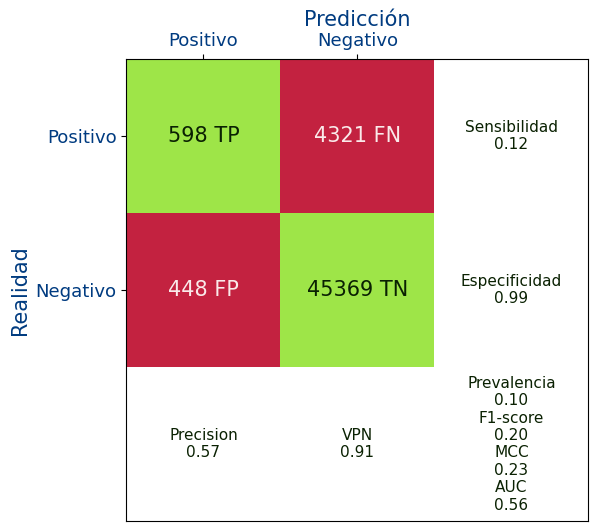

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
Tasa_Falsos_Positivos (%): 0.88
Tasa_Falsos_Negativos (%): 8.52
Tasa_Verdaderos_Positivos (%): 1.18
Tasa_Verdaderos_Negativos (%): 89.42


In [43]:
# 8. Obtener métricas finales
y_pred_final = (model.predict(X_test) > 0.5).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
prevalencia = (tp + fn) / len(y_test)
f1 = f1_score(y_test, y_pred_final)
mcc = matthews_corrcoef(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_pred_final)

# 9. Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(6, 6))
plot_matriz_confusion(ax, TP=tp, TN=tn, FP=fp, FN=fn, vpp=precision, vpn=npv,
                      sensibilidad=sensibilidad, especificidad=especificidad, 
                      f1_score=f1, mcc=mcc, auc=auc, prevalencia=prevalencia)
plt.show()

def calcular_metricas_matriz_confusion(y_true, y_pred, threshold=0.5):
    y_pred_binario = (y_pred > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binario).ravel()

    total = len(y_true)
    metricas = {
        "Tasa_Falsos_Positivos (%)": (fp / total) * 100,
        "Tasa_Falsos_Negativos (%)": (fn / total) * 100,
        "Tasa_Verdaderos_Positivos (%)": (tp / total) * 100,
        "Tasa_Verdaderos_Negativos (%)": (tn / total) * 100
    }
    return metricas

# Uso del método
metricas_finales = calcular_metricas_matriz_confusion(y_test, model.predict(X_test))
for k, v in metricas_finales.items():
    print(f"{k}: {v:.2f}")

### considerando que con este modelo1 con umbral 0.5 tenemos:
* 598 TP (pesonas con ataque del corazon detectadas) 1.18% del total
* 4321 FN (personas que no hemos detectado con ataque al corazon ) 8.52% del total
* 448 FP (persona que hemos detectado con ataque al corazon pero mal) 0.88 del total
* 45369 TN (personas que hemos detectado bien que no tenian ataque al corazon) 89.42% del total
* perdidas para la mejor etapa 11:  loss: 0.2368 - val_loss: 0.2414
### puede que venga dado por un desbalance en la clase de datos, como vimos antes:
* 229,787 instancias con HeartDiseaseorAttack = 0 (no tienen enfermedad cardíaca)
* 23,893 instancias con HeartDiseaseorAttack = 1 (tienen enfermedad cardíaca)
### la proporcion es de aproximadamente de 10 a 1 por lo que el modelo va a tender a precedir mas FP y FN, en la siguiente versión del modelo (version 2) vamos a dar mas peso a las personas con ataque al corazón para que detecte mejor los positivos

### Pérdida, sensibilidad(Recall), especificidad por época modelo1

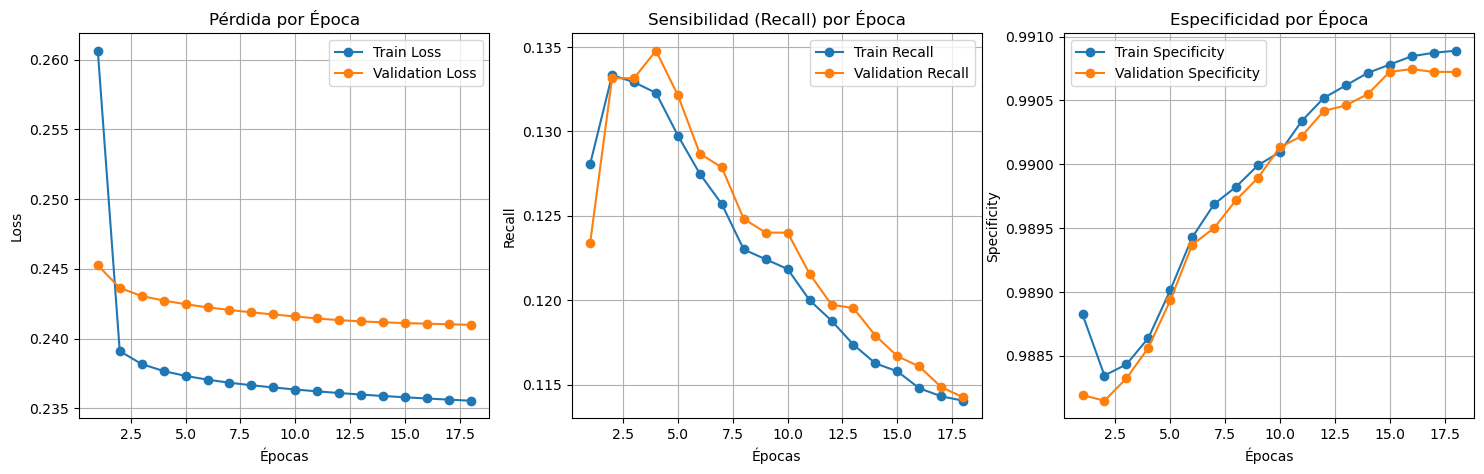

In [44]:
# Extraer datos
epochs = df_metrics["Epoch"]
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
recall_train = df_metrics["Recall_train"]
recall_test = df_metrics["Recall_test"]
specificity_train = df_metrics["Specificity_train"]
specificity_test = df_metrics["Specificity_test"]

# Figura y subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 📉 Gráfico 1: Pérdida (Loss)
axes[0].plot(epochs, loss_train, label="Train Loss", marker="o")
axes[0].plot(epochs, loss_val, label="Validation Loss", marker="o")
axes[0].set_title("Pérdida por Época")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# 📈 Gráfico 2: Sensibilidad (Recall)
axes[1].plot(epochs, recall_train, label="Train Recall", marker="o")
axes[1].plot(epochs, recall_test, label="Validation Recall", marker="o")
axes[1].set_title("Sensibilidad (Recall) por Época")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid()

# 📊 Gráfico 3: Especificidad (Specificity)
axes[2].plot(epochs, specificity_train, label="Train Specificity", marker="o")
axes[2].plot(epochs, specificity_test, label="Validation Specificity", marker="o")
axes[2].set_title("Especificidad por Época")
axes[2].set_xlabel("Épocas")
axes[2].set_ylabel("Specificity")
axes[2].legend()
axes[2].grid()

# Mostrar gráficos
plt.show()

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


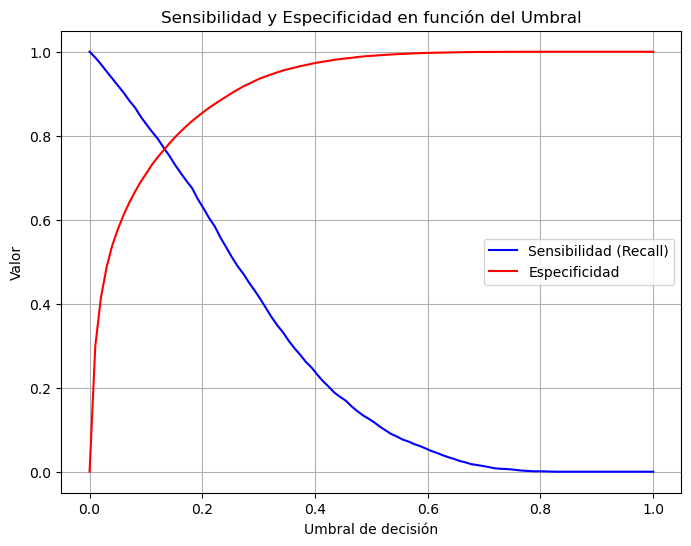

In [45]:
# Obtener probabilidades de predicción en el conjunto de prueba
y_pred_probs = model.predict(X_test)

# Definir umbrales de decisión
thresholds = np.linspace(0, 1, 100)  # 100 valores entre 0 y 1

# Listas para almacenar sensibilidad y especificidad
sensitivities = []
specificities = []

# Calcular sensibilidad y especificidad para cada umbral
for threshold in thresholds:
    y_pred_binary = (y_pred_probs >= threshold).astype(int)  # Convertir a 0 o 1 según umbral
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Sensibilidad (Recall)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivities.append(recall)

    # Especificidad
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Graficar sensibilidad y especificidad en función del umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivities, label="Sensibilidad (Recall)", color='blue')
plt.plot(thresholds, specificities, label="Especificidad", color='red')

# Configuración del gráfico
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Sensibilidad y Especificidad en función del Umbral")
plt.legend()
plt.grid()
plt.show()


## Entrenamiento del modelo 2 con:
* (NUEVO) 5+3 capas (64, (64)+3, 32, 16, 1) elu, sigmoid
* (NUEVO) umbral 0.3
* (NUEVO) (learning_rate=0.00005)
* early-stop (min_delta=0.001 y patience=7)
* (NUEVO) 100 épocas
### Además se le ha añadido mas peso a los positivos

In [46]:
# 1. Cargar los datos y preprocesarlos
X = df.iloc[:, 1:].values  # Variables predictoras
y = df.iloc[:, 0].values   # Variable objetivo

# 2. Establecer la semilla para reproducibilidad
np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# 4. Callback para calcular Sensibilidad y Especificidad
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochs_log = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = (model2.predict(X_train) > 0.3).astype("int32")
        y_pred_test = (model2.predict(X_test) > 0.3).astype("int32")

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        specificity_train = tn_train / (tn_train + fp_train) if (tn_train + fp_train) > 0 else 0
        specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

        log_entry = {
            "Epoch": epoch + 1,
            "Recall_train": recall_train,
            "Specificity_train": specificity_train,
            "Recall_test": recall_test,
            "Specificity_test": specificity_test,
        }
        self.epochs_log.append(log_entry)

# 5. Construir el modelo2
model2 = Sequential([
    Dense(64, activation="elu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="elu"),
    Dense(64, activation="elu"),
    Dense(64, activation="elu"),
    Dense(64, activation="elu"),
    Dense(32, activation="elu"),
    Dense(16, activation="elu"),
    Dense(1, activation="sigmoid")
])

# 6. Compilar el modelo2
model2.compile(optimizer=Adam(learning_rate=0.00005), loss="binary_crossentropy")

# 7. Establecer los pesos de clase para la clase 1 (enfermedad cardíaca)
class_weight = {0: 1., 1: 10.}  # Aumentamos el peso de la clase 1

# 8. Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,         # Cambio mínimo más pequeño que se considere una mejora
    patience=7,
    verbose=1,               # Puedes activar verbose para ver información
    mode='auto',
    restore_best_weights=True  # Para recuperar el modelo con mejor validación
)

# 9. Entrenar el modelo2 con el callback de métricas y ajuste de pesos
metrics_callback = MetricsCallback()
history = model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                     class_weight=class_weight,  # Aplicar los pesos de clase
                     callbacks=[metrics_callback, early_stop])

# 10. Guardar métricas para análisis posterior
df_metrics = pd.DataFrame(metrics_callback.epochs_log)

# TIEMPO: 26min 17.7s (Portatil casa)

Epoch 1/100


/home/domi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6342/6342 ━━━━━━━━━━━━━━━━━━━━ 5s 778us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0371 - val_loss: 0.5690
Epoch 2/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 5s 744us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.9008 - val_loss: 0.5553
Epoch 3/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 5s 752us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8940 - val_loss: 0.5479
Epoch 4/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 5s 824us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.8912 - val_loss: 0.5437
Epoch 5/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 5s 717us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8895 - val_loss: 0.5393
Epoch 6/100
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 707us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step
6342/6342 

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step


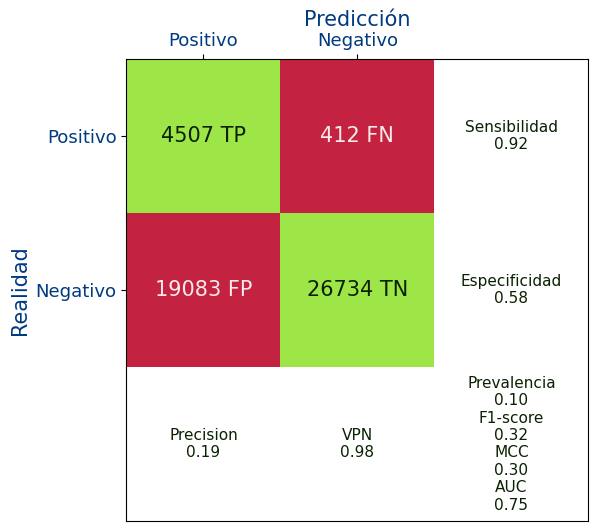

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
Tasa_Falsos_Positivos (%): 37.61
Tasa_Falsos_Negativos (%): 0.81
Tasa_Verdaderos_Positivos (%): 8.88
Tasa_Verdaderos_Negativos (%): 52.69


In [47]:
# 8. Obtener métricas finales
y_pred_final = (model2.predict(X_test) > 0.3).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
prevalencia = (tp + fn) / len(y_test)
f1 = f1_score(y_test, y_pred_final)
mcc = matthews_corrcoef(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_pred_final)

# 9. Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(6, 6))
plot_matriz_confusion(ax, TP=tp, TN=tn, FP=fp, FN=fn, vpp=precision, vpn=npv,
                      sensibilidad=sensibilidad, especificidad=especificidad, 
                      f1_score=f1, mcc=mcc, auc=auc, prevalencia=prevalencia)
plt.show()
def calcular_metricas_matriz_confusion(y_true, y_pred, threshold=0.3):
    y_pred_binario = (y_pred > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binario).ravel()

    total = len(y_true)
    metricas = {
        "Tasa_Falsos_Positivos (%)": (fp / total) * 100,
        "Tasa_Falsos_Negativos (%)": (fn / total) * 100,
        "Tasa_Verdaderos_Positivos (%)": (tp / total) * 100,
        "Tasa_Verdaderos_Negativos (%)": (tn / total) * 100
    }
    return metricas

# Uso del método
metricas_finales = calcular_metricas_matriz_confusion(y_test, model2.predict(X_test))
for k, v in metricas_finales.items():
    print(f"{k}: {v:.2f}")


### considerando que con este modelo 2 tenemos:
* 4507 TP (pesonas con ataque del corazon detectadas) 8.88% del total
* 412 FN (personas que no hemos detectado con ataque al corazon ) 0.81% del total
* 19083 FP (persona que hemos detectado con ataque al corazon pero mal) 37.61% del total
* 26734 TN (personas que hemos detectado bien que no tenian ataque al corazon) 52.69% del total

### Aunque le hayamos dado más peso a los positivos (pesonas con ataque al corazón) vemos que los datos obtenidos en la matrix de confusión son malos:
* Sensibilidad de 0.92
* Especificidad 0.58
* Precision 0.19
### y además tenemos registros en la última etapa de entrenamiento de la pérdida de:
* loss: loss: 0.8665 - val_loss: 0.4838

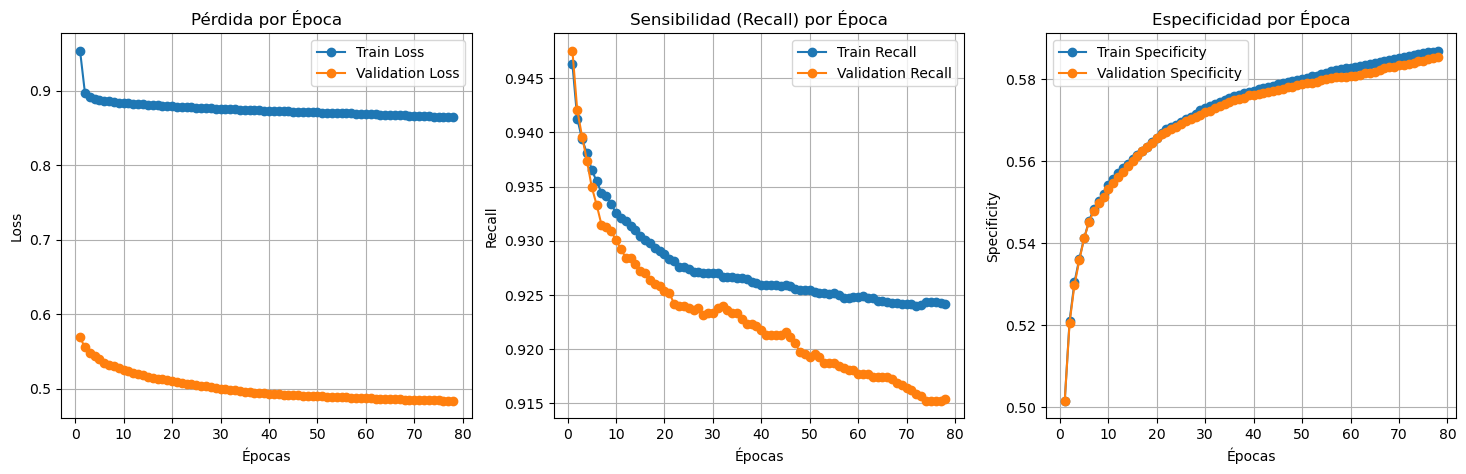

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


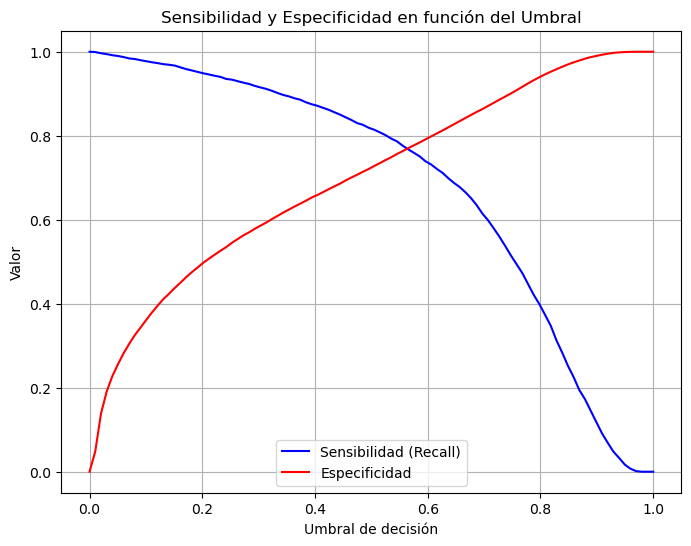

In [48]:
# Extraer datos
epochs = df_metrics["Epoch"]
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
recall_train = df_metrics["Recall_train"]
recall_test = df_metrics["Recall_test"]
specificity_train = df_metrics["Specificity_train"]
specificity_test = df_metrics["Specificity_test"]

# Figura y subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 📉 Gráfico 1: Pérdida (Loss)
axes[0].plot(epochs, loss_train, label="Train Loss", marker="o")
axes[0].plot(epochs, loss_val, label="Validation Loss", marker="o")
axes[0].set_title("Pérdida por Época")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# 📈 Gráfico 2: Sensibilidad (Recall)
axes[1].plot(epochs, recall_train, label="Train Recall", marker="o")
axes[1].plot(epochs, recall_test, label="Validation Recall", marker="o")
axes[1].set_title("Sensibilidad (Recall) por Época")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid()

# 📊 Gráfico 3: Especificidad (Specificity)
axes[2].plot(epochs, specificity_train, label="Train Specificity", marker="o")
axes[2].plot(epochs, specificity_test, label="Validation Specificity", marker="o")
axes[2].set_title("Especificidad por Época")
axes[2].set_xlabel("Épocas")
axes[2].set_ylabel("Specificity")
axes[2].legend()
axes[2].grid()

# Mostrar gráficos
plt.show()

# Obtener probabilidades de predicción en el conjunto de prueba
y_pred_probs = model2.predict(X_test)

# Definir umbrales de decisión
thresholds = np.linspace(0, 1, 100)  # 100 valores entre 0 y 1

# Listas para almacenar sensibilidad y especificidad
sensitivities = []
specificities = []

# Calcular sensibilidad y especificidad para cada umbral
for threshold in thresholds:
    y_pred_binary = (y_pred_probs >= threshold).astype(int)  # Convertir a 0 o 1 según umbral
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Sensibilidad (Recall)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivities.append(recall)

    # Especificidad
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Graficar sensibilidad y especificidad en función del umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivities, label="Sensibilidad (Recall)", color='blue')
plt.plot(thresholds, specificities, label="Especificidad", color='red')

# Configuración del gráfico
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Sensibilidad y Especificidad en función del Umbral")
plt.legend()
plt.grid()
plt.show()


### conclusiones modelo 2:
* el modelo se ha vuelto demasiado agresivo en predecir positivos (por los pesos y el umbral mas bajo)
### Ahora detecta bien a casi todos los verdaderos positivos (TP) pero al costo de generar demasiados falsos positivos (FP)
### Lo que podemos hacer para un modelo 3:
* Ajustar umbral de clasificación (subirlo para  intentar equilibrar los valores de modelo 1 y 2)
* Ajustar pesos de clase (probar con 1:5 o 1:3) para buscar un valor intermedio entre modelo 1 y 2
* Reducir le numero de capas/neuronas (64, 64, 32, 16, 1)


## Entrenamiento del modelo 3 con:
* (NUEVO) 5 (64, 32, 16, 16, 1) relu(NUEVO), sigmoid
* (NUEVO) umbral 0.14
* (NUEVO) learning_rate=0.0005 (si perdida oscila mucho, lo bajamos)
* early-stop (min_delta=0.001 y patience=10)
* (NUEVO) 40 épocas (no he notado resultado en pruebas poniendo mcuhas épocas que con tan pocas)
* (NUEVO) Dropout del 0.2(para evitar le overfitting), menos en la ultima capa oculta (mejora la estabilidad de la red)
### Además se ha tocado el peso de las clases:
* de 1:10, probar con 1:2.5

In [ ]:
# 1. Cargar los datos y preprocesarlos
X = df.iloc[:, 1:].values  # Variables predictoras
y = df.iloc[:, 0].values   # Variable objetivo

# 2. Establecer la semilla para reproducibilidad
np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# 4. Callback para calcular Sensibilidad y Especificidad
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochs_log = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = (model3.predict(X_train) > 0.18).astype("int32")  # Nuevo umbral 0.15
        y_pred_test = (model3.predict(X_test) > 0.18).astype("int32")

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        specificity_train = tn_train / (tn_train + fp_train) if (tn_train + fp_train) > 0 else 0
        specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

        log_entry = {
            "Epoch": epoch + 1,
            "Recall_train": recall_train,
            "Specificity_train": specificity_train,
            "Recall_test": recall_test,
            "Specificity_test": specificity_test,
        }
        self.epochs_log.append(log_entry)

# 5. Construir el modelo3 con relu, sigmoid y Dropout
model3 = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.15),
    Dense(32, activation="relu"),
    Dropout(0.15),
    Dense(16, activation="relu"),
    Dropout(0.15),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

# 6. Compilar el modelo3 con nuevo learning rate
model3.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy")

# 7. Ajustar los pesos de clase (1:2.5)
class_weight = {0: 1., 1: 2.5}

# 8. Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

# 9. Entrenar el modelo3 con 40 épocas
metrics_callback = MetricsCallback()
history = model3.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
                     class_weight=class_weight,  
                     callbacks=[metrics_callback, early_stop])

# 10. Guardar métricas para análisis posterior
df_metrics = pd.DataFrame(metrics_callback.epochs_log)

# TIEMPO: 9min 25s (Portatil casa)


Epoch 1/50


/home/domi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 615us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5381 - val_loss: 0.2986
Epoch 2/50
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 633us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.4455 - val_loss: 0.2843
Epoch 3/50
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.4391 - val_loss: 0.2758
Epoch 4/50
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 624us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.4351 - val_loss: 0.2756
Epoch 5/50
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.4333 - val_loss: 0.2715
Epoch 6/50
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 4s 635us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step
6342/6342 ━━━━━

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step


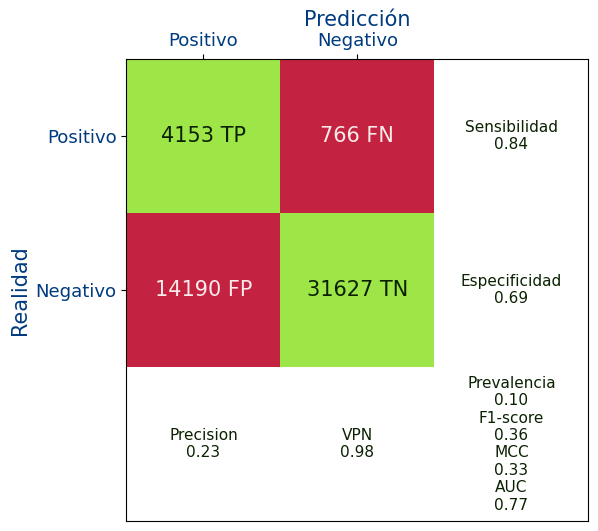

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step
Tasa_Falsos_Positivos (%): 27.97
Tasa_Falsos_Negativos (%): 1.51
Tasa_Verdaderos_Positivos (%): 8.19
Tasa_Verdaderos_Negativos (%): 62.34


In [50]:
# 8. Obtener métricas finales
y_pred_final = (model3.predict(X_test) > 0.18).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
prevalencia = (tp + fn) / len(y_test)
f1 = f1_score(y_test, y_pred_final)
mcc = matthews_corrcoef(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_pred_final)

# 9. Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(6, 6))
plot_matriz_confusion(ax, TP=tp, TN=tn, FP=fp, FN=fn, vpp=precision, vpn=npv,
                      sensibilidad=sensibilidad, especificidad=especificidad, 
                      f1_score=f1, mcc=mcc, auc=auc, prevalencia=prevalencia)
plt.show()
def calcular_metricas_matriz_confusion(y_true, y_pred, threshold=0.18):
    y_pred_binario = (y_pred > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binario).ravel()

    total = len(y_true)
    metricas = {
        "Tasa_Falsos_Positivos (%)": (fp / total) * 100,
        "Tasa_Falsos_Negativos (%)": (fn / total) * 100,
        "Tasa_Verdaderos_Positivos (%)": (tp / total) * 100,
        "Tasa_Verdaderos_Negativos (%)": (tn / total) * 100
    }
    return metricas

# Uso del método
metricas_finales = calcular_metricas_matriz_confusion(y_test, model3.predict(X_test))
for k, v in metricas_finales.items():
    print(f"{k}: {v:.2f}")

# print(f"Tamaño total del dataset: {len(y)}")
# print(f"Tamaño de y_train: {len(y_train)}")
# print(f"Tamaño de y_test: {len(y_test)}")


### conclusiones modelo 3:
* el modelo se ha intentado equilibrar para sacar la mayor sensibilidad y especificidad (mezclando técnicas del 1 y 2)
### Ahora tenemos 0.84 de sensibilidad y 0.69 de especificidad:
* mandariamos al hospital a 14190 personas con falsos positivos pero detectaríamos a 31627
* salvariamos detectando a 4153 personas y 766 se nos morirían
### Lo que podemos hacer para futuro modelo:
* explorar nuevas ténicas
* limpiar los datos o centrarnos en un pequeño porcentaje de estos y cuando tengamos un modelo estable, partir de el para entrenar futuros modelos o sacar un modelo persoanlizado para cada caso

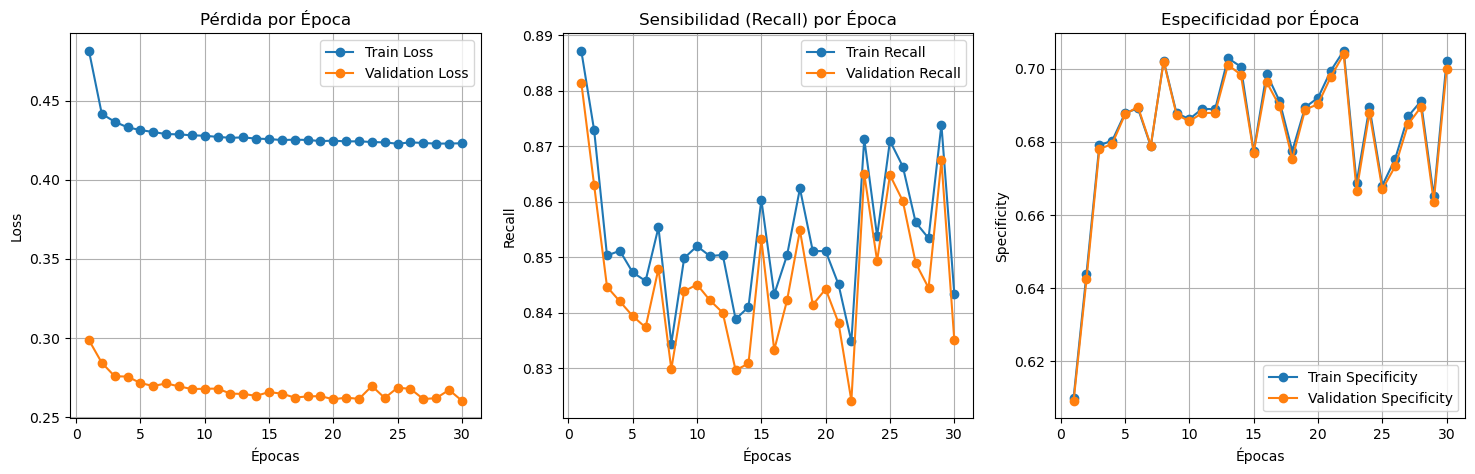

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step


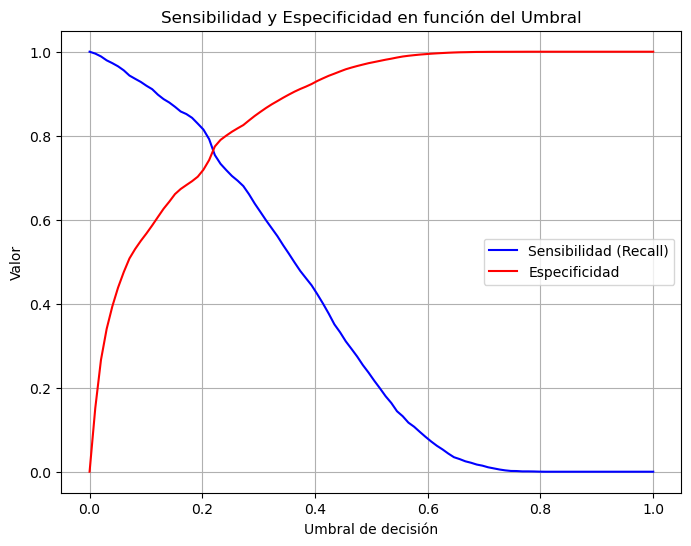

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step


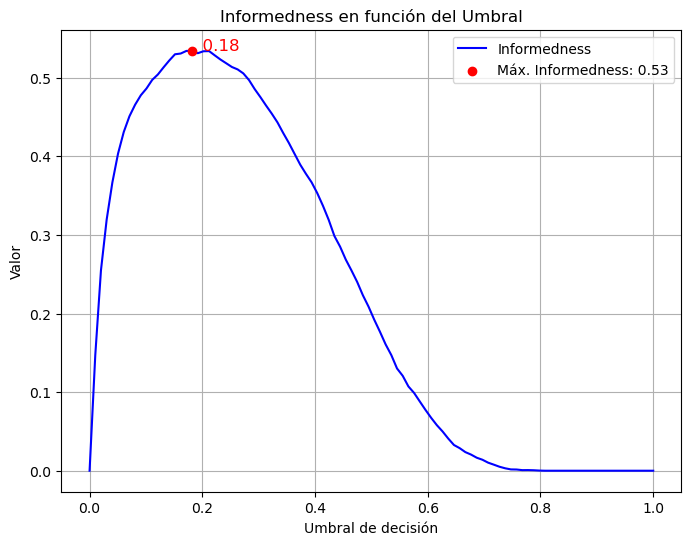

In [ ]:
# Extraer datos
epochs = df_metrics["Epoch"]
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
recall_train = df_metrics["Recall_train"]
recall_test = df_metrics["Recall_test"]
specificity_train = df_metrics["Specificity_train"]
specificity_test = df_metrics["Specificity_test"]

# Figura y subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 📉 Gráfico 1: Pérdida (Loss)
axes[0].plot(epochs, loss_train, label="Train Loss", marker="o")
axes[0].plot(epochs, loss_val, label="Validation Loss", marker="o")
axes[0].set_title("Pérdida por Época")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# 📈 Gráfico 2: Sensibilidad (Recall)
axes[1].plot(epochs, recall_train, label="Train Recall", marker="o")
axes[1].plot(epochs, recall_test, label="Validation Recall", marker="o")
axes[1].set_title("Sensibilidad (Recall) por Época")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid()

# 📊 Gráfico 3: Especificidad (Specificity)
axes[2].plot(epochs, specificity_train, label="Train Specificity", marker="o")
axes[2].plot(epochs, specificity_test, label="Validation Specificity", marker="o")
axes[2].set_title("Especificidad por Época")
axes[2].set_xlabel("Épocas")
axes[2].set_ylabel("Specificity")
axes[2].legend()
axes[2].grid()

# Mostrar gráficos
plt.show()

# Obtener probabilidades de predicción en el conjunto de prueba
y_pred_probs = model3.predict(X_test)

# Definir umbrales de decisión
thresholds = np.linspace(0, 1, 100)  # 100 valores entre 0 y 1

# Listas para almacenar sensibilidad y especificidad
sensitivities = []
specificities = []

# Calcular sensibilidad y especificidad para cada umbral
for threshold in thresholds:
    y_pred_binary = (y_pred_probs >= threshold).astype(int)  # Convertir a 0 o 1 según umbral
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Sensibilidad (Recall)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivities.append(recall)

    # Especificidad
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Graficar sensibilidad y especificidad en función del umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivities, label="Sensibilidad (Recall)", color='blue')
plt.plot(thresholds, specificities, label="Especificidad", color='red')

# Configuración del gráfico
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Sensibilidad y Especificidad en función del Umbral")
plt.legend()
plt.grid()
plt.show()

# Obtener probabilidades de predicción en el conjunto de prueba
y_pred_probs = model3.predict(X_test)

# Definir umbrales de decisión
thresholds = np.linspace(0, 1, 100)  # 100 valores entre 0 y 1

# Listas para almacenar sensibilidad y especificidad
informedness = []

# Calcular sensibilidad y especificidad para cada umbral
for threshold in thresholds:
    y_pred_binary = (y_pred_probs >= threshold).astype(int)  # Convertir a 0 o 1 según umbral
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Sensibilidad (Re
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    #Informedness
    informedness.append(recall + specificity - 1)

# Encontrar el umbral con mayor informedness
max_informedness = max(informedness)
best_threshold = thresholds[np.argmax(informedness)]

# Graficar informedness en función del umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, informedness, label="Informedness", color='blue')

# Marcar el punto con el mayor informedness
plt.scatter(best_threshold, max_informedness, color='red', zorder=3, label=f'Máx. Informedness: {max_informedness:.2f}')
plt.text(best_threshold, max_informedness, f'  {best_threshold:.2f}', color='red', fontsize=12)

# Configuración del gráfico
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Informedness en función del Umbral")
plt.legend()
plt.grid()
plt.show()


## Entrenamiento del modelo 4 con:
* (NUEVO) 5 (128, 64, 32, 16, 1) (NUEVO)--> relu(primera capa), tanh(intermedias) y sigmoid(ultima)
* (NUEVO) learning_rate=0.0003 (para intentar estabilizar el aprendizajemejorar TP y TN)
* (NUEVO) Aumentar el tamaño del conjunto de entrenamiento (test_size=0.15 o 0.10)
* (NUEVO) Añadir Batch Normalization, permite:
    * Reducir la varianza interna, haciendo el aprendizaje más estable.
    * Reducir la dependencia del aprendizaje en el batch size.
    * Permitir usar learning rates más altos, acelerando la convergencia.
    * Reducir el sobreajuste (overfitting), mejorando la generalización.
### Además se ha tocado el peso de las clases:
* 1:2.

In [ ]:
# 1. Cargar los datos y preprocesarlos
X = df.iloc[:, 1:].values  # Variables predictoras
y = df.iloc[:, 0].values   # Variable objetivo

# 2. Establecer la semilla para reproducibilidad
np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=45)

# 4. Callback para calcular Sensibilidad y Especificidad
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochs_log = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = (model4.predict(X_train) > 0.18).astype("int32")
        y_pred_test = (model4.predict(X_test) > 0.18).astype("int32")

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        specificity_train = tn_train / (tn_train + fp_train) if (tn_train + fp_train) > 0 else 0
        specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

        log_entry = {
            "Epoch": epoch + 1,
            "Recall_train": recall_train,
            "Specificity_train": specificity_train,
            "Recall_test": recall_test,
            "Specificity_test": specificity_test,
        }
        self.epochs_log.append(log_entry)

# 5. Construir el modelo4 con BatchNormalization añadido
model4 = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),  # Normalización después de la capa Dense
    Dropout(0.15),

    Dense(64, activation="tanh"),
    BatchNormalization(),
    Dropout(0.15),

    Dense(32, activation="tanh"),
    BatchNormalization(),
    Dropout(0.15),

    Dense(16, activation="tanh"),
    BatchNormalization(),

    Dense(1, activation="sigmoid")  # No necesita BatchNormalization en la salida
])

# 6. Compilar el modelo4 con nuevo learning rate
model4.compile(optimizer=Adam(learning_rate=0.0003), loss="binary_crossentropy")

# 7. Ajustar los pesos de clase (1:2.5)
class_weight = {0: 1., 1: 2.}

# 8. Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

# 9. Entrenar el modelo4 con 50 épocas
metrics_callback = MetricsCallback()
history = model4.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
                     class_weight=class_weight,  
                     callbacks=[metrics_callback, early_stop])

# 10. Guardar métricas para análisis posterior
df_metrics = pd.DataFrame(metrics_callback.epochs_log)

# TIEMPO: 11min 2s (Portatil casa)


Epoch 1/50


/home/domi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7135/7135 ━━━━━━━━━━━━━━━━━━━━ 7s 935us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.4921 - val_loss: 0.2866
Epoch 2/50
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 6s 876us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.3906 - val_loss: 0.2877
Epoch 3/50
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 6s 827us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.3882 - val_loss: 0.2784
Epoch 4/50
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 6s 816us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.3853 - val_loss: 0.2631
Epoch 5/50
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 6s 770us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.3841 - val_loss: 0.2704
Epoch 6/50
7135/7135 ━━━━━━━━━━━━━━━━━━━━ 6s 802us/step
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
7135/7135 ━━━━━━━━━━━━━━━━━

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step


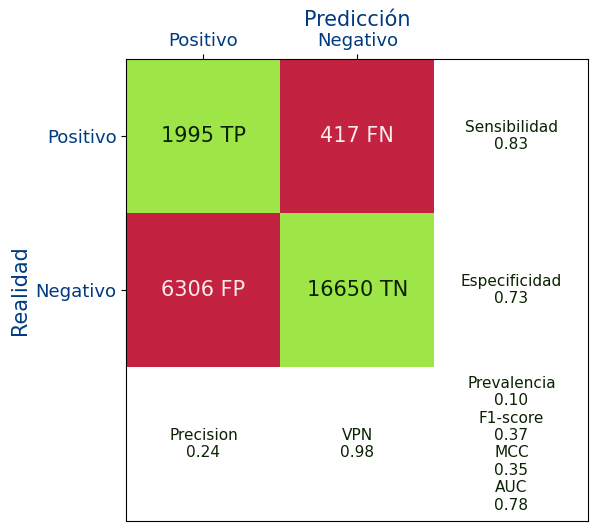

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step
Tasa_Falsos_Positivos (%): 24.86
Tasa_Falsos_Negativos (%): 1.64
Tasa_Verdaderos_Positivos (%): 7.86
Tasa_Verdaderos_Negativos (%): 65.63


In [53]:
# 8. Obtener métricas finales
y_pred_final = (model4.predict(X_test) > 0.18).astype("int32")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
prevalencia = (tp + fn) / len(y_test)
f1 = f1_score(y_test, y_pred_final)
mcc = matthews_corrcoef(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_pred_final)

# 9. Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(6, 6))uc=auc, prevalencia=prevalencia)
plt.show()
def calcular_metricas_matriz_confusion(y_true, y_pred, threshold=0.18):
    y_pred_binario = (y_pred > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binario).ravel()

    total = len(y_true)
    metricas = {
        "Tasa_Falsos_Positivos (%)": (fp / total) * 100,
        "Tasa_Falsos_Negativos (%)": (fn / total) * 100,
        "Tasa_Verdaderos_Positivos (%)": (tp / total) * 100,
        "Tasa_Verdaderos_Negativos (%)": (tn / total) * 100
    }
    return metricas

# Uso del método
metricas_finales = calcular_metricas_matriz_confusion(y_test, model4.predict(X_test))
for k, v in metricas_finales.items():
    print(f"{k}: {v:.2f}")

#print(f"Tamaño total del dataset: {len(y)}")
#print(f"Tamaño de y_train: {len(y_train)}")
#print(f"Tamaño de y_test: {len(y_test)}")

### Datos:
* 1995 TP (pesonas con ataque del corazon detectadas) 7.86% del total
* 417 FN (personas que no hemos detectado con ataque al corazon ) 1.64% del total
* 6306 FP (persona que hemos detectado con ataque al corazon pero mal) 24.86% del total
* 16650 TN (personas que hemos detectado bien que no tenian ataque al corazon) 65.63% del total

## COMPARACIONES

## 📊 Comparación de Modelos

### 🔹 Modelo 1:
* **598 TP** (personas con ataque del corazón detectadas) → **1.18% del total**
* **4321 FN** (personas que no hemos detectado con ataque al corazón) → **8.52% del total**
* **448 FP** (personas que hemos detectado con ataque al corazón, pero mal) → **0.88% del total**
* **45369 TN** (personas que hemos detectado bien que no tenían ataque al corazón) → **89.42% del total**

### 🔹 Modelo 2:
* **4507 TP** (personas con ataque del corazón detectadas) → **8.88% del total**
* **412 FN** (personas que no hemos detectado con ataque al corazón) → **0.81% del total**
* **19083 FP** (personas que hemos detectado con ataque al corazón, pero mal) → **37.61% del total**
* **26734 TN** (personas que hemos detectado bien que no tenían ataque al corazón) → **52.69% del total**

### 🔹 Modelo 3:
* **4153 TP** (personas con ataque del corazón detectadas) → **8.19% del total**
* **766 FN** (personas que no hemos detectado con ataque al corazón) → **1.51% del total**
* **14190 FP** (personas que hemos detectado con ataque al corazón, pero mal) → **27.97% del total**
* **31627 TN** (personas que hemos detectado bien que no tenían ataque al corazón) → **62.34% del total**

### 🔹 Modelo 4:
* **1995 TP** (personas con ataque del corazón detectadas) → **7.86% del total**
* **417 FN** (personas que no hemos detectado con ataque al corazón) → **1.64% del total**
* **6306 FP** (personas que hemos detectado con ataque al corazón, pero mal) → **24.86% del total**
* **16650 TN** (personas que hemos detectado bien que no tenían ataque al corazón) → **65.63% del total**

---

## 📊 Tabla Comparativa de Tasas

| Modelo   | Tasa_Falsos_Positivos (%) | Tasa_Falsos_Negativos (%) | Tasa_Verdaderos_Positivos (%) | Tasa_Verdaderos_Negativos (%) |
|----------|--------------------------|--------------------------|------------------------------|------------------------------|
| Modelo 1 | 0.88                     | 8.52                     | 1.18                         | 89.42                        |
| Modelo 2 | 37.61                    | 0.81                     | 8.88                         | 52.69                        |
| Modelo 3 | 27.97                    | 1.51                     | 8.19                         | 62.34                        |
| Modelo 4 | 24.86                    | 1.64                     | 7.86                         | 65.63                        |




## Resultados de las matrices de confusión

### Modelo 1 y Modelo 2
![Modelo 1](image.png)![Modelo 2](Imagen2.png)

### Modelo 3 y Modelo 4
![Modelo 3](Imagen3.png)![Modelo 4](Imagen4.png)
